### Advanced Lane Finding

In [1]:
import numpy as np
import cv2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import pickle
import glob
import os

(1280, 720)


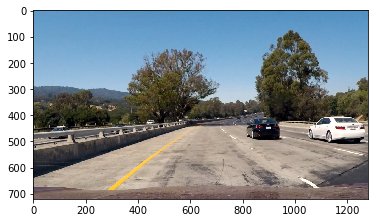

In [2]:
img = mpimg.imread('test_images/test1.jpg')
plt.imshow(img)
img_size = (img.shape[1], img.shape[0])
print(img_size)

### Pipeline implementation

In [3]:
# Combining above steps into function

def caliberate_camera( chess_board_row, chess_board_col, img_size = (1280, 720), imgs_location = "camera_cal/calibration*.jpg"):
    
    objp = np.zeros((chess_board_row*chess_board_col,3), np.float32)
    objp[:,:2] = np.mgrid[0:chess_board_row, 0:chess_board_col].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    import glob
    images = glob.glob(imgs_location)

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (chess_board_row, chess_board_col), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    return mtx, dist

def warp_image(img, mtx, dist):
    
    # undistort image from camera correction
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    
    # warp image
    img_size = (img.shape[1], img.shape[0])
    
    src = np.float32(
        [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
        [((img_size[0] / 6) - 10), img_size[1]],
        [(img_size[0] * 5 / 6) + 60, img_size[1]],
        [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warpped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warpped, M, Minv, dst

# filters to identify lane markings

def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(20, 100)):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobel_axis = cv2.Sobel(gray, cv2.CV_64F, (orient is 'x'), (orient is 'y' ))
    abs_sobel = np.absolute(sobel_axis)
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a mask of 1's where the scaled gradient magnitude is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

def mag_thresh(image, sobel_kernel=3, mag_thresh=(30, 100)):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    abs_sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    abs_sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    
    abs_sobel = np.sqrt(abs_sobelx**2 + abs_sobely**2)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1

    return binary_output

def dir_threshold(image, sobel_kernel=3, thresh=(0.7, 1.3)):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    abs_sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    abs_sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    
    grad_sobel = np.arctan2(abs_sobely, abs_sobelx)
    binary_output = np.zeros_like(grad_sobel)
    binary_output[(grad_sobel >= thresh[0]) & (grad_sobel <= thresh[1])] = 1

    return binary_output

In [4]:
t1,t2 = caliberate_camera(9,6)

### Complete Processing

In [49]:
global count
global left_fit
global right_fit
count = 0

def video_process(img, mtx, dist):
    img_size = (img.shape[1], img.shape[0])
    
    warped_img, M, Minv, dst = warp_image(img, mtx, dist)
    
    # applying filters
    ksize = 7

    gradx = None
    mag_binary = None
    dir_binary = None
    gradx = abs_sobel_thresh(warped_img, orient='x', sobel_kernel=ksize)
    mag_binary = mag_thresh(warped_img, sobel_kernel=ksize)
    dir_binary = dir_threshold(warped_img, sobel_kernel=ksize)

    combined = np.zeros_like(dir_binary)
    combined[(gradx == 1) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    hls = cv2.cvtColor(warped_img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    binary_S = np.zeros_like(S)
    binary_S[(S >= 160) & (S <= 255)] = 1
    
    binary_final = np.zeros_like(S)
    binary_final[(binary_S == 1) | (combined == 1)] = 1
    
    
    histogram = np.sum(binary_final[binary_final.shape[0]//2:,:], axis=0)
    ### finding lanes
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_final, binary_final, binary_final))

    # Find the peak of the left and right halves of the histogram
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_final.shape[0]/nwindows)
    
    global count
    if count is 0:
        count+=1 # to avoid window sliding in next image
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_final.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 60

        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []


        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_final.shape[0] - (window+1)*window_height
            win_y_high = binary_final.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 3) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 3) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))


        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # Fit a second order polynomial to each
        global left_fit
        global right_fit
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        ploty = np.linspace(0, binary_final.shape[0]-1, binary_final.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    else:
        # Assume you now have a new warped binary image 
        # from the next frame of video (also called "binary_warped")
        # It's now much easier to find line pixels!
        nonzero = binary_final.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        
        global left_fit
        global right_fit
        
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_final.shape[0]-1, binary_final.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Calculate offset
    rightx_int = right_fit[0]*720**2 + right_fit[1]*720 + right_fit[2]
    leftx_int = left_fit[0]*720**2 + left_fit[1]*720 + left_fit[2]
    center = abs(640 - ((rightx_int+leftx_int)/2))
    
    # Drawing on normal image
    #
    warp_zero = np.zeros_like(binary_final).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.flipud(np.transpose(np.vstack([left_fitx, ploty])))])
    pts_right = np.array([np.transpose(np.vstack([right_fitx, ploty]))])
    pts = np.hstack((pts_left, pts_right))
    cv2.polylines(color_warp, np.int_([pts]), isClosed=False, color=(0,0,255), thickness = 40)
    cv2.fillPoly(color_warp, np.int_(pts), (34,255,34))
    newwarp = cv2.warpPerspective(color_warp, Minv, (binary_final.shape[1], binary_final.shape[0]))
    result = cv2.addWeighted(img, 1, newwarp, 0.5, 0)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    text1 = "Radius of Curvature: {} m".format(int(left_curverad/2 + right_curverad/2))
    text2 = "Offset from Center: {:.2f} m".format(center*3.7/700)
    cv2.putText(result,text1,(400,100), font, 1,(255,255,255),2)
    cv2.putText(result,text2,(400,200), font, 1,(255,255,255),2)
    
    return result

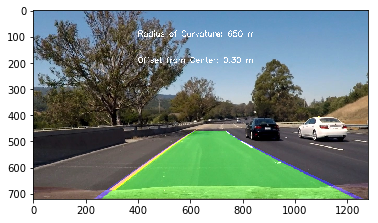

In [48]:
img2 = mpimg.imread('test_images/test6.jpg')
temp = video_process(img2, t1, t2)
plt.imshow(temp)

#### Video Processing

In [38]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [50]:
output = 'project_video_output2.mp4'
clip1 = VideoFileClip('project_video.mp4')
clip = clip1.fl_image(lambda x: video_process(x, t1, t2)) #NOTE: this function expects color images!!
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output2.mp4
[MoviePy] Writing video project_video_output2.mp4


100%|█████████████████████████████████████▉| 1260/1261 [06:01<00:00,  3.16it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output2.mp4 

Wall time: 6min 4s


In [51]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))